In [1]:
import seaborn as sns
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt

from utils import (
    get_runs, get_fitness_vars, get_variable_properties, get_generated_rooms,
    feedback_mapping, vars_columns
)

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [2]:
folder_path = './figs/fitness_vars_analysis/'

In [3]:
runs = get_runs()
fitness_vars = get_fitness_vars()
generated_rooms = get_generated_rooms()
variable_properties = get_variable_properties()

# Pergunta de pesquisa: "Quais variáveis de fitness influenciam mais a dificuldade percebida pelos jogadores?"

In [4]:
merged_df = pd.merge(runs, fitness_vars, left_on='fitness_vars_id', right_on='id')
merged_df = merged_df.drop(columns=['id_y'])

correct_feedback_df = merged_df[merged_df['player_feedback'] == merged_df['actual_difficulty']]
correct_feedback_df = correct_feedback_df[correct_feedback_df['player_feedback'] != '']

incorrect_feedback_df = merged_df[merged_df['player_feedback'] != merged_df['actual_difficulty']]
incorrect_feedback_df = incorrect_feedback_df[incorrect_feedback_df['player_feedback'] != '']

## Correlação

NumEnemiesGroup                  -0.004928
AverageEnemiesPerGroup           -0.020993
AverageEnemyDoorDistance         -0.039790
AverageBetweenEnemiesDistances    0.017972
AverageObstaclesNextToEnemies    -0.011230
AverageEnemiesWithCover          -0.001168
matched_difficulty                1.000000
Name: matched_difficulty, dtype: float64


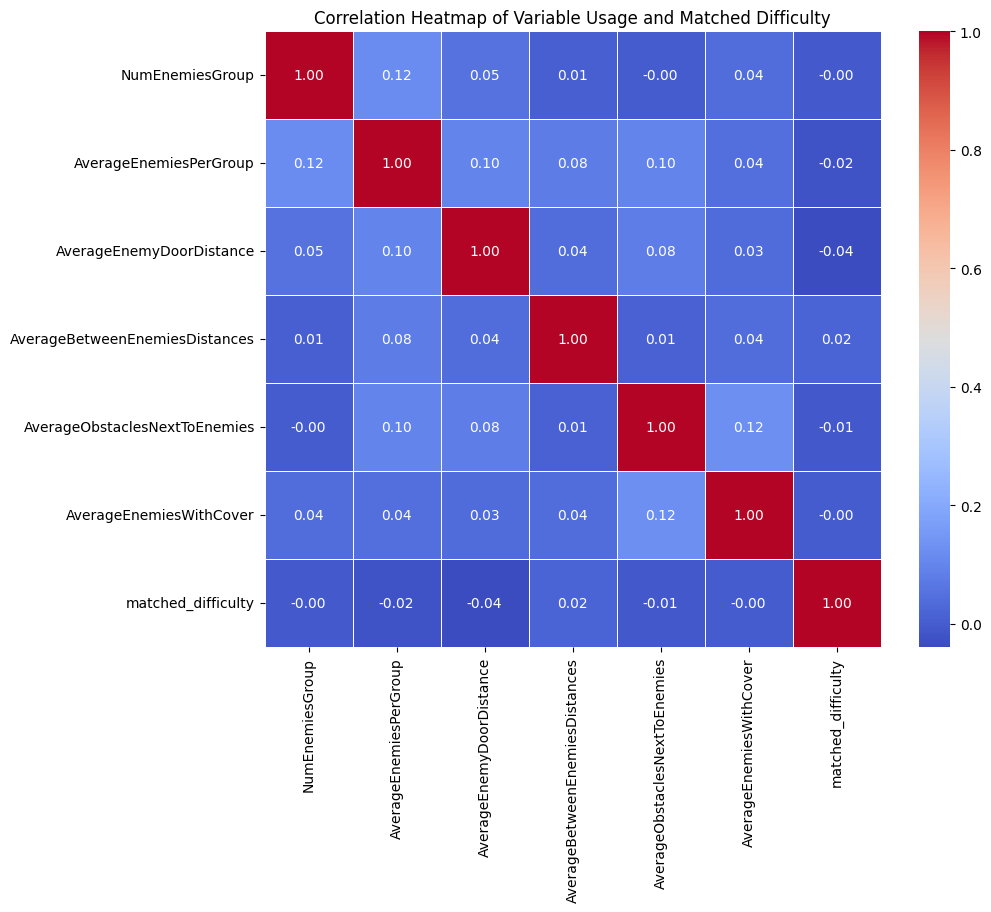

In [5]:
merged_df['matched_difficulty'] = (merged_df['player_feedback'] == merged_df['actual_difficulty']).astype(int)
binary_df = merged_df[vars_columns].notna().astype(int)
binary_df['matched_difficulty'] = merged_df['matched_difficulty']
binary_df.columns = [col.replace('Id', '') for col in binary_df.columns]

correlation = binary_df.corr()

print(correlation['matched_difficulty'])

plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f', square=True, linewidths=0.5)
plt.title('Correlation Heatmap of Variable Usage and Matched Difficulty')
plt.show()

### Conclusões

A partir dessas correlações, é possível concluir que as variáveis relacionadas ao design da sala (número de inimigos, média de inimigos por grupo, distâncias entre inimigos e obstáculos) não estão se correlacionando de maneira significativa com a habilidade dos jogadores em acertar a dificuldade. Isso sugere que outros fatores podem ser mais influentes na percepção de dificuldade, como a dinâmica do jogo, a experiência do jogador ou elementos não mensuráveis no design da sala.

## Importância de Variáveis

In [6]:
X = binary_df.drop(columns=['matched_difficulty'])
y = binary_df['matched_difficulty']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

model = LogisticRegression()
model.fit(X_resampled, y_resampled)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)

print(f'Acurácia: {accuracy}')
print(f'Matriz de Confusão:\n{confusion}')

coef = pd.Series(model.coef_[0], index=X.columns)
print(coef)

Acurácia: 0.4835164835164835
Matriz de Confusão:
[[35 30]
 [17  9]]
NumEnemiesGroup                   0.113395
AverageEnemiesPerGroup           -0.463694
AverageEnemyDoorDistance         -0.601529
AverageBetweenEnemiesDistances    0.180126
AverageObstaclesNextToEnemies    -0.502887
AverageEnemiesWithCover          -0.948861
dtype: float64


Acurácia: 0.5494505494505495
Matriz de Confusão:
[[42 23]
 [18  8]]
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.70      0.65      0.67        65
           1       0.26      0.31      0.28        26

    accuracy                           0.55        91
   macro avg       0.48      0.48      0.48        91
weighted avg       0.57      0.55      0.56        91

Importância das Variáveis:
AverageBetweenEnemiesDistances    0.195651
AverageObstaclesNextToEnemies     0.191281
NumEnemiesGroup                   0.174053
AverageEnemiesPerGroup            0.171442
AverageEnemiesWithCover           0.135130
AverageEnemyDoorDistance          0.132444
dtype: float64


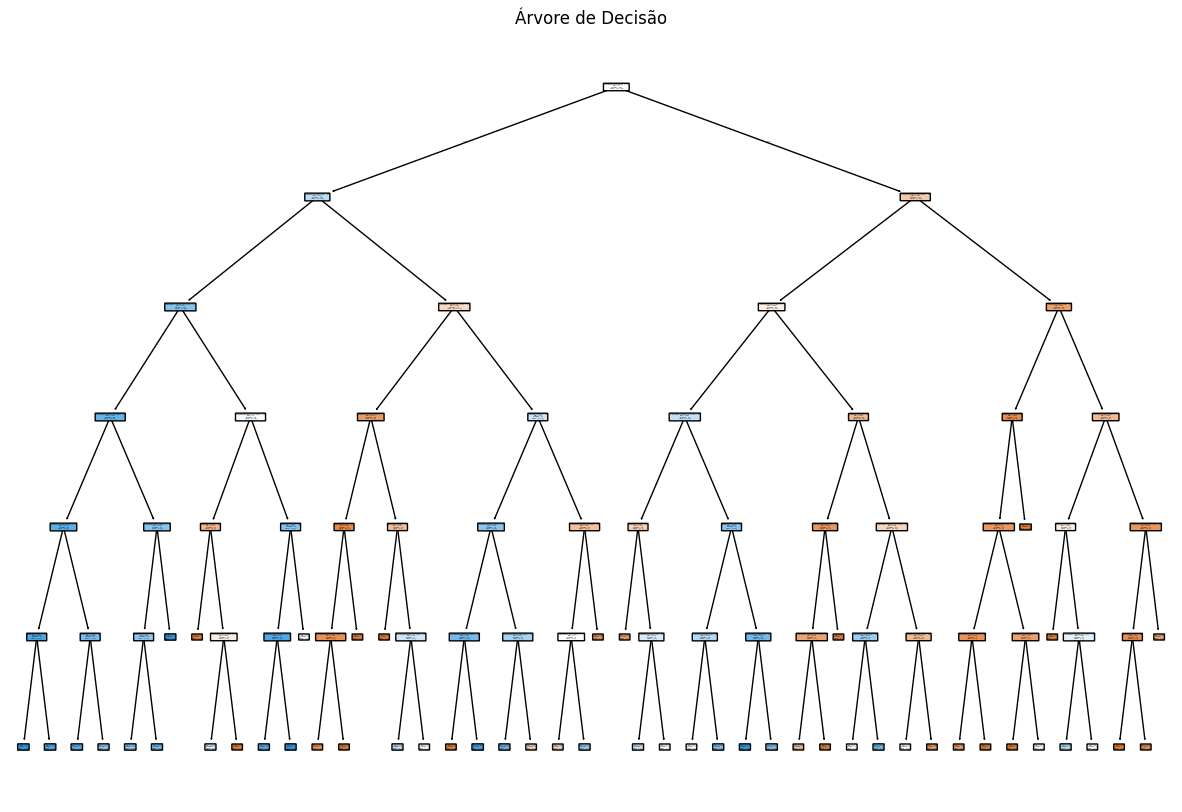

In [7]:
X = binary_df.drop(columns=['matched_difficulty'])
y = binary_df['matched_difficulty']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_resampled, y_resampled)

y_pred = tree_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Acurácia: {accuracy}')
print(f'Matriz de Confusão:\n{confusion}')
print(f'Relatório de Classificação:\n{report}')

importances = pd.Series(tree_model.feature_importances_, index=X.columns)
print(f'Importância das Variáveis:\n{importances.sort_values(ascending=False)}')

plt.figure(figsize=(15, 10))
plot_tree(tree_model, feature_names=X.columns, class_names=['Erro', 'Acerto'], filled=True, rounded=True)
plt.title("Árvore de Decisão")
plt.show()

## Testes de Hipóteses

In [12]:
for column in X.columns:
    group1 = binary_df[binary_df['matched_difficulty'] == 1][column]
    group0 = binary_df[binary_df['matched_difficulty'] == 0][column]
    
    t_stat, p_value = stats.ttest_ind(group1.dropna(), group0.dropna())
    print(f'{column} - p-value: {p_value}')

NumEnemiesGroup - p-value: 0.931920201668077
AverageEnemiesPerGroup - p-value: 0.7158927924733618
AverageEnemyDoorDistance - p-value: 0.49017877901190554
AverageBetweenEnemiesDistances - p-value: 0.7553717866300208
AverageObstaclesNextToEnemies - p-value: 0.8456405825765994
AverageEnemiesWithCover - p-value: 0.9838452851065228


## Análise de Interação

In [13]:
interaction_model = ols('matched_difficulty ~ NumEnemiesGroup * AverageEnemiesPerGroup', data=binary_df).fit()
anova_table = sm.stats.anova_lm(interaction_model, typ=2)
print(anova_table)

                                           sum_sq     df         F    PR(>F)
NumEnemiesGroup                          0.000357    1.0  0.001914  0.965132
AverageEnemiesPerGroup                   0.023647    1.0  0.126624  0.722210
NumEnemiesGroup:AverageEnemiesPerGroup   0.064451    1.0  0.345123  0.557330
Residual                                55.837936  299.0       NaN       NaN


## Validação Cruzada

In [14]:
cross_val_scores = cross_val_score(model, X, y, cv=5)
print(f'Acurácia média na validação cruzada: {cross_val_scores.mean()}')

Acurácia média na validação cruzada: 0.7557923497267759


## Análise de Resíduos

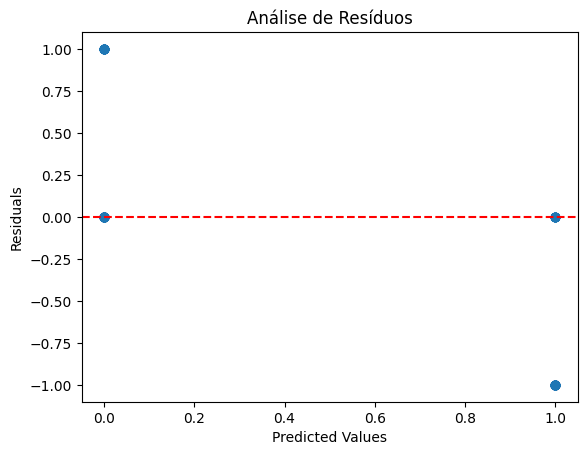

In [15]:
residuals = y_test - y_pred

plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Análise de Resíduos')
plt.show()

## Conclusões

Com base nesses resultados, é possível concluir que nenhuma variável individualmente nem qualquer combinação de variáveis se destaca como relevante para o jogador acertar o feedback da dificuldade, uma vez que a performance e a significância estatística não apontam para relevância forte ou consistência.

1. **Análise da Acurácia**

	Acurácia do modelo: Com uma acurácia geral de cerca de 48% no conjunto de teste, o modelo não está se saindo bem em prever corretamente o feedback do jogador. Isso está abaixo do esperado para um modelo útil, indicando que ele tem quase a mesma precisão de uma escolha aleatória.

	Matriz de Confusão: O modelo confunde frequentemente as classes (acertar ou errar a dificuldade), com uma grande proporção de predições incorretas para ambas as classes.

2. **Importância das Variáveis**

	Valores de Coeficientes: Nenhuma das variáveis apresenta um coeficiente positivo expressivo; na verdade, a maioria dos coeficientes é negativa, com o maior sendo para AverageEnemiesWithCover (-0.95), indicando uma leve influência inversa. Porém, coeficientes negativos altos sem significância podem indicar que o modelo está superajustado a ruídos nos dados.

3. **Testes de Hipóteses**

	p-values elevados: Todos os valores p estão muito acima do limiar de significância (0.05), indicando que as variáveis independentes não são estatisticamente significativas para prever matched_difficulty. Isso significa que a hipótese nula (de que essas variáveis não têm efeito sobre matched_difficulty) não pode ser rejeitada, sugerindo que elas têm pouco ou nenhum impacto relevante.

4. **Análise de Interação**

	Interações sem significância: A análise das interações também revela valores p muito altos (acima de 0.5), mostrando que mesmo a combinação de variáveis, como NumEnemiesGroup e AverageEnemiesPerGroup, não é significativa. As interações entre as variáveis não têm um efeito estatisticamente relevante em matched_difficulty.

5. **Validação Cruzada**

	Acurácia na Validação Cruzada: A média de acurácia de 75% na validação cruzada é ligeiramente mais alta, mas ainda não o suficiente para sustentar que o modelo seja robusto. Isso pode indicar alguma variabilidade no desempenho, mas ainda assim, está longe de indicar um padrão de relevância clara para qualquer variável.

**Conclusão Final**

Os resultados indicam que não há evidências estatísticas fortes para afirmar que alguma variável ou combinação de variáveis tenha uma relevância significativa na previsão do acerto de dificuldade pelo jogador. Dada a baixa significância e o desempenho modesto, é provável que essas variáveis não influenciem fortemente o feedback do jogador, ou que o controle da dificuldade dependa de fatores externos não capturados por essas variáveis.

## Variáveis mais usadas quando o player acertou a dificuldade

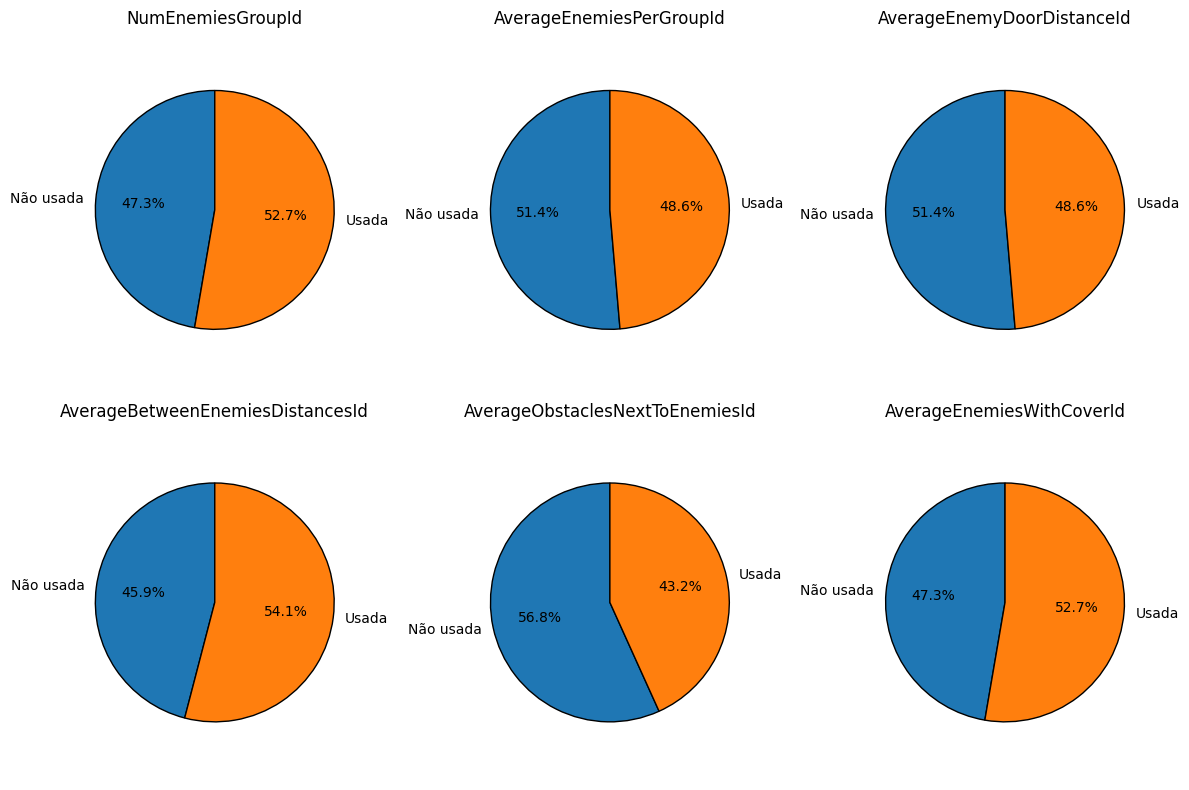

In [16]:
plt.figure(figsize=(12, 8))
for i, var_column in enumerate(vars_columns):
    count_nan = correct_feedback_df[var_column].isna().sum()
    count_not_nan = correct_feedback_df[var_column].notna().sum()

    labels = ['Não usada', 'Usada']
    sizes = [count_nan, count_not_nan]

    plt.subplot(2, 3, i+1)
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, wedgeprops={'edgecolor': 'black'})
    plt.title(f'{var_column}')
    plt.axis('equal')
plt.tight_layout()
plt.savefig(f'{folder_path}/completion_distribution_pie.png', dpi=96, bbox_inches='tight')
plt.show()

## Variáveis mais usadas quando o player errou a dificuldade

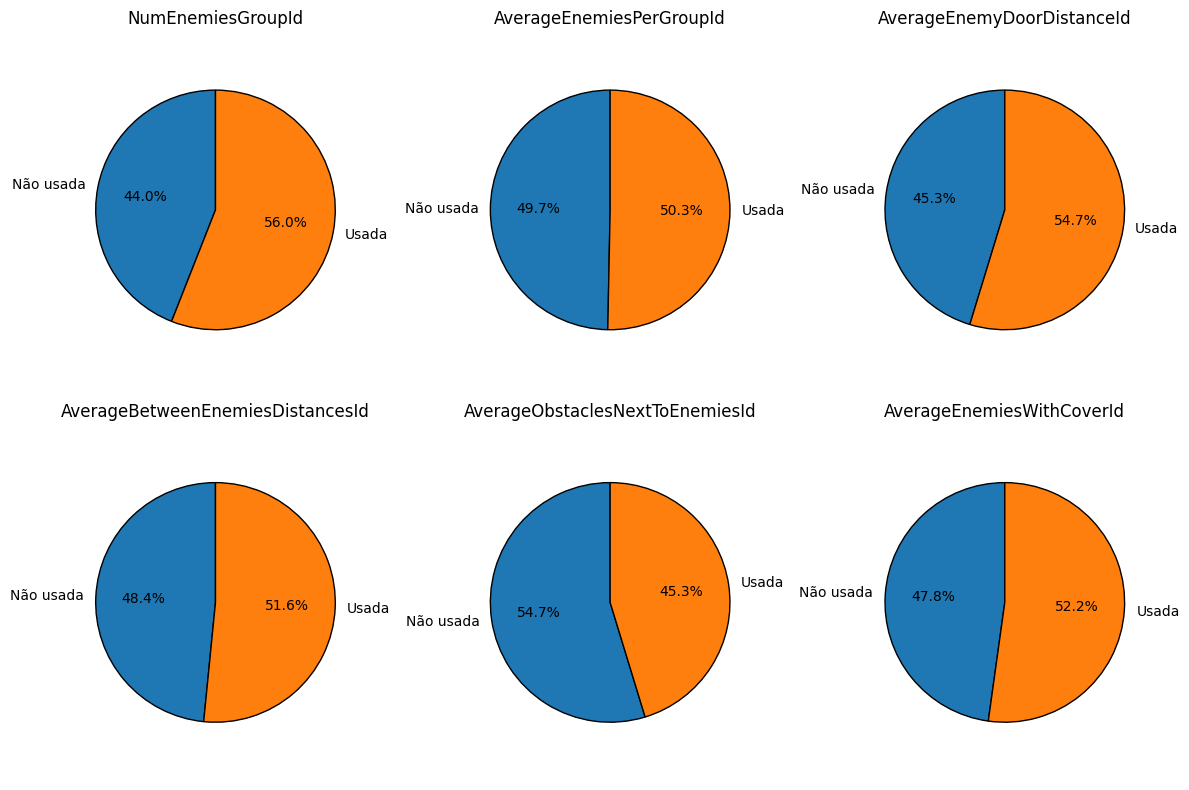

In [17]:
plt.figure(figsize=(12, 8))
for i, var_column in enumerate(vars_columns):
    count_nan = incorrect_feedback_df[var_column].isna().sum()
    count_not_nan = incorrect_feedback_df[var_column].notna().sum()

    labels = ['Não usada', 'Usada']
    sizes = [count_nan, count_not_nan]

    plt.subplot(2, 3, i+1)
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, wedgeprops={'edgecolor': 'black'})
    plt.title(f'{var_column}')
    plt.axis('equal')

plt.tight_layout()
plt.savefig(f'{folder_path}/completion_distribution_pie_wrong_feedback.png', dpi=96, bbox_inches='tight')
plt.show()

## Correlação entre as variáveis de fitness e a dificuldade percebida e o tempo

In [18]:
fitness_vars_usage = merged_df.copy()
fitness_vars_usage[vars_columns] = merged_df[vars_columns].notna()
fitness_vars_usage[vars_columns] = fitness_vars_usage[vars_columns].astype(int)

                                  player_feedback_encoded      time
NumEnemiesGroupId                                0.027247 -0.031694
AverageEnemiesPerGroupId                         0.068214 -0.001547
AverageEnemyDoorDistanceId                       0.022106 -0.062410
AverageBetweenEnemiesDistancesId                -0.074337  0.039859
AverageObstaclesNextToEnemiesId                  0.031912  0.031404
AverageEnemiesWithCoverId                       -0.085433  0.015487
player_feedback_encoded                          1.000000  0.234651
time                                             0.234651  1.000000


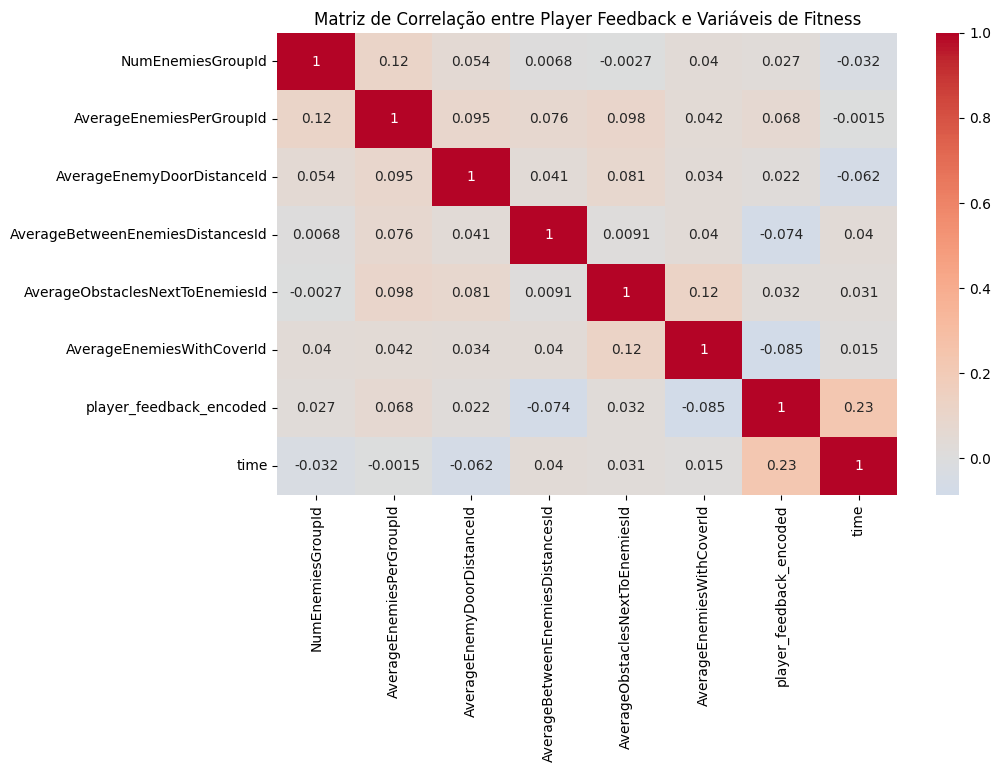

In [19]:
fitness_vars_usage['player_feedback_encoded'] = fitness_vars_usage['player_feedback'].map(feedback_mapping)

correlation = fitness_vars_usage[vars_columns + ['player_feedback_encoded', 'time']].corr()

print(correlation[['player_feedback_encoded', 'time']])

plt.figure(figsize=(10, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0)
plt.title("Matriz de Correlação entre Player Feedback e Variáveis de Fitness")
plt.savefig(f'{folder_path}/player_feedback_correlation.png', dpi=96, bbox_inches='tight')
plt.show()

## Conclusões

**Primeiro Gráfico (Jogadores que acertaram a dificuldade):**

Variáveis como NumEnemiesGroupId, AverageBetweenEnemiesDistancesId e AverageEnemiesWithCoverId são usadas com uma frequência ligeiramente maior quando os jogadores acham que a dificuldade da sala foi percebida corretamente.

Essas variáveis parecem ter uma influência maior na experiência de jogo. Em particular, as distâncias entre os inimigos e o fato de estarem cobertos ou não (em relação ao posicionamento) podem ser fatores importantes na percepção da dificuldade pelos jogadores.

**Segundo Gráfico (Jogadores que erraram a dificuldade):**

Aqui, a maior diferença aparece na variável AverageObstaclesNextToEnemiesId, que foi usada menos vezes quando os jogadores sentiram que erraram na percepção da dificuldade.

Isso pode indicar que obstáculos perto dos inimigos podem ajudar na percepção correta da dificuldade, ou que salas sem essa consideração foram percebidas de maneira inconsistente em termos de dificuldade.

**Tabela de Correlação:**

As correlações mostradas são pequenas, o que indica que nenhuma variável de fitness tem um impacto fortemente isolado na percepção da dificuldade (player_feedback_encoded) ou no tempo.

No entanto, duas variáveis se destacam:

AverageEnemiesWithCoverId tem uma correlação negativa mais forte com a dificuldade percebida (-0.085). Isso pode indicar que mais inimigos com cobertura podem reduzir a percepção de dificuldade ou confundir os jogadores, levando-os a acharem a sala mais fácil do que é.

AverageBetweenEnemiesDistancesId também tem uma correlação negativa (-0.074), sugerindo que quando os inimigos estão muito dispersos, os jogadores tendem a subestimar a dificuldade.

**Conclusões Preliminares:**

Parece que as variáveis de distâncias entre inimigos e cobertura influenciam mais na percepção de dificuldade dos jogadores.

Quando o posicionamento dos inimigos e obstáculos leva em conta essas variáveis, a dificuldade parece ser percebida de forma mais consistente.

A correlação com o tempo também mostra que os jogadores percebem uma correlação (ainda que fraca) entre o tempo gasto e a dificuldade da sala, o que é esperado, pois salas mais difíceis tendem a demandar mais tempo.